In [25]:
# change tissue position parquet to csv for squidpy loading
import pandas as pd
import os

# 1. Define your paths
base_path = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_visium_data/HUK1_COR1"
spatial_folder = os.path.join(base_path, "spatial")

parquet_file = os.path.join(spatial_folder, "tissue_positions.parquet")
csv_output = os.path.join(spatial_folder, "tissue_positions.csv")

# 2. Convert the file
df = pd.read_parquet(parquet_file)
if 'barcode' in df.columns:
    df = df.set_index('barcode')
df.to_csv(csv_output)

/opt/miniconda3/envs/medsam/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/miniconda3/envs/medsam/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


Used genes:
  pod : ['NPHS1', 'NPHS2', 'PODXL', 'WT1', 'SYNPO', 'PTPRO']
  endo: ['KDR', 'EMCN', 'PECAM1', 'FLT1']
  tub : ['SLC34A1', 'LRP2', 'UMOD', 'SLC12A1', 'AQP2']
Connected components found: 79 (before area filtering)
Regions kept after area filter: 78
Wrote: HUK1_COR1_out/candidate_regions_bboxes_level0.csv
Wrote: HUK1_COR1_out/candidate_regions_bboxes_level0.geojson

Next: open the NDPI in QuPath, then import objects from:
  HUK1_COR1_out/candidate_regions_bboxes_level0.geojson
🔥 Plotting GlomScore Heatmap...
🟩 Plotting Candidate Regions...
Saved visualization to: HUK1_COR1_out/candidate_heatmap_preview.png


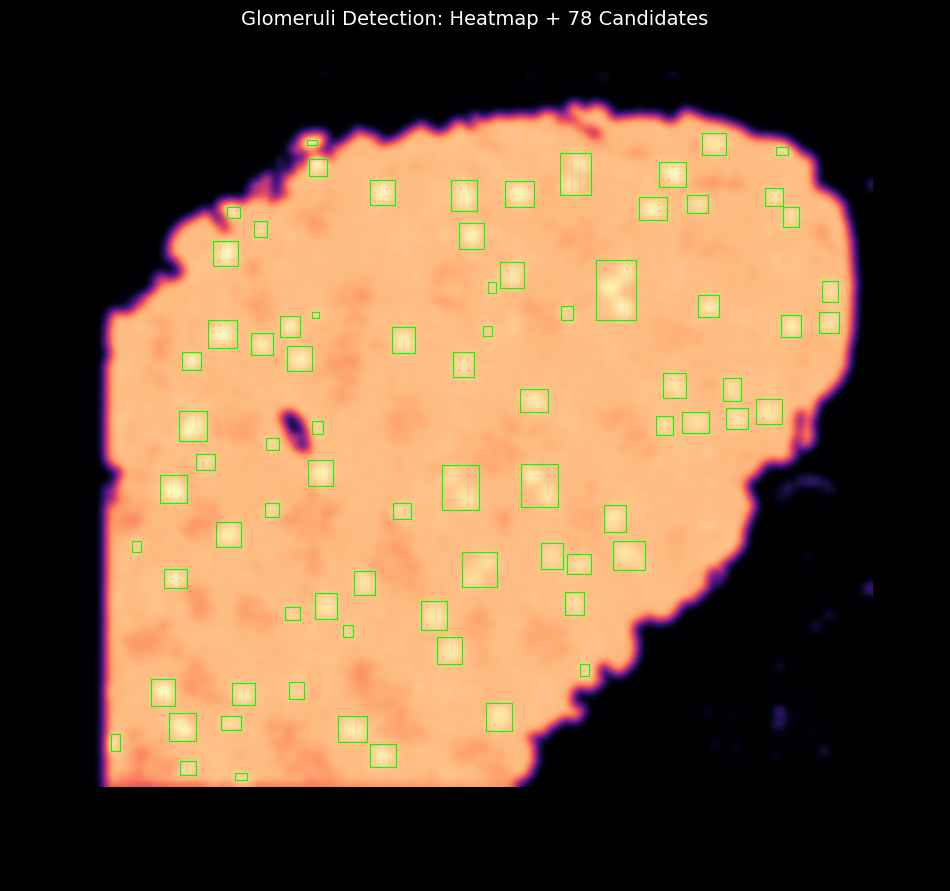

In [1]:
# generate glomeruli candidates from visium expression data

import os
import json
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter, label, find_objects

# --- Your paths ---
VISIUM_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_visium_data/HUK1_COR1"
WHOLE_SLIDE_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_visium_data/HUK1_COR1/HUK1_COR_1.tif"

# --- Output ---
OUTDIR = "HUK1_COR1_out"
os.makedirs(OUTDIR, exist_ok=True)

# --- Heatmap / ROI parameters (meaningful knobs; no arbitrary K) ---
DOWN = 16.0          # level-0 pixels per heatmap pixel (bigger = smaller heatmap)
SIGMA = 6            # gaussian smoothing in heatmap pixels (bigger = larger blobs)
PCTL = 97            # keep top (100-PCTL)% of heatmap values as "glomerulus-like"
MIN_REGION_AREA = 50 # min connected-component area in heatmap pixels to keep (removes tiny noise)

# --- Marker sets (Human-style casing) ---
POD = ["NPHS1", "NPHS2", "PODXL", "WT1", "SYNPO", "PTPRO"]
ENDO = ["KDR", "EMCN", "PECAM1", "FLT1"]
TUB  = ["SLC34A1", "LRP2", "UMOD", "SLC12A1", "AQP2"]

# ---------------------------
# 1) Load Visium as AnnData
# ---------------------------
import squidpy as sq
adata = sq.read.visium(VISIUM_PATH)

# Ensure unique var_names (fixes InvalidIndexError)
adata.var_names_make_unique()
if adata.raw is not None:
    adata.raw.var_names_make_unique()

# ---------------------------------------------------
# 3) Compute GlomScore from marker sets
# ---------------------------------------------------
def _get_X(adata, genes):
    genes = [g for g in genes if g in adata.var_names]
    if len(genes) == 0:
        return None, []
    X = adata.raw[:, genes].X if adata.raw is not None else adata[:, genes].X
    if sp.issparse(X):
        X = X.toarray()
    return X, genes

def zmean(adata, genes):
    X, used = _get_X(adata, genes)
    if X is None:
        return None, []
    Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
    return Xz.mean(axis=1), used

pod_s, pod_used   = zmean(adata, POD)
endo_s, endo_used = zmean(adata, ENDO)
tub_s, tub_used   = zmean(adata, TUB)

score = np.zeros(adata.n_obs, dtype=np.float32)
pos_terms = 0

for s in [pod_s, endo_s]:
    if s is not None:
        score += s.astype(np.float32)
        pos_terms += 1

if pos_terms > 0:
    score /= pos_terms

if tub_s is not None:
    score -= tub_s.astype(np.float32)

adata.obs["GlomScore"] = score

print("Used genes:")
print("  pod :", pod_used)
print("  endo:", endo_used)
print("  tub :", tub_used)

if (pod_s is None) and (endo_s is None):
    raise RuntimeError(
        "No podocyte/endothelial genes were found in adata.var_names. "
        "Your var_names may be Ensembl IDs or different casing."
    )

# ---------------------------------------------------
# 4) Rasterize GlomScore into a grid + smooth
# ---------------------------------------------------
xy = adata.obsm["spatial"].astype(np.float32)
x = xy[:, 0]
y = xy[:, 1]
vals = adata.obs["GlomScore"].values.astype(np.float32)

xd = (x / DOWN).astype(np.int32)
yd = (y / DOWN).astype(np.int32)

W = int(xd.max() + 1)
H = int(yd.max() + 1)

acc = np.zeros((H, W), dtype=np.float32)
cnt = np.zeros((H, W), dtype=np.int32)

for xi, yi, v in zip(xd, yd, vals):
    if 0 <= yi < H and 0 <= xi < W:
        acc[yi, xi] += v
        cnt[yi, xi] += 1

grid = np.full((H, W), np.nan, dtype=np.float32)
mask = cnt > 0
grid[mask] = acc[mask] / cnt[mask]

minv = np.nanmin(grid)
grid_filled = np.where(np.isnan(grid), minv, grid)

heat = gaussian_filter(grid_filled, sigma=SIGMA)

# ---------------------------------------------------
# 5) Threshold + connected components (NO arbitrary K)
# ---------------------------------------------------
thr = np.percentile(heat, PCTL)
binary = heat > thr

lbl, ncomp = label(binary)
print(f"Connected components found: {ncomp} (before area filtering)")

slices = find_objects(lbl)

regions = []
for comp_id, slc in enumerate(slices, start=1):
    if slc is None:
        continue
    ys, xs = slc  # slices for y and x
    y0g, y1g = ys.start, ys.stop
    x0g, x1g = xs.start, xs.stop

    region_mask = (lbl[ys, xs] == comp_id)
    area = int(region_mask.sum())
    if area < MIN_REGION_AREA:
        continue

    # bbox in level-0 pixels
    x0 = float(x0g * DOWN)
    x1 = float(x1g * DOWN)
    y0 = float(y0g * DOWN)
    y1 = float(y1g * DOWN)

    # also store center
    xc = (x0 + x1) / 2.0
    yc = (y0 + y1) / 2.0

    regions.append({
        "id": len(regions),
        "x0": x0, "y0": y0, "x1": x1, "y1": y1,
        "x_center": xc, "y_center": yc,
        "area_gridpx": area,
        "threshold": float(thr),
        "percentile": float(PCTL),
        "down": float(DOWN),
        "sigma": float(SIGMA),
    })

print(f"Regions kept after area filter: {len(regions)}")

# ---------------------------------------------------
# 6) Export CSV + GeoJSON for QuPath
# ---------------------------------------------------
bbox_df = pd.DataFrame(regions)
csv_path = os.path.join(OUTDIR, "candidate_regions_bboxes_level0.csv")
bbox_df.to_csv(csv_path, index=False)
print("Wrote:", csv_path)

features = []
for r in regions:
    coords = [[
        [r["x0"], r["y0"]],
        [r["x1"], r["y0"]],
        [r["x1"], r["y1"]],
        [r["x0"], r["y1"]],
        [r["x0"], r["y0"]],
    ]]
    features.append({
        "type": "Feature",
        "geometry": {"type": "Polygon", "coordinates": coords},
        "properties": {
            "name": f"GlomRegion_{r['id']}",
            "id": int(r["id"]),
            "area_gridpx": int(r["area_gridpx"]),
            "pctl": float(PCTL),
        }
    })

geo = {"type": "FeatureCollection", "features": features}
geo_path = os.path.join(OUTDIR, "candidate_regions_bboxes_level0.geojson")
with open(geo_path, "w") as f:
    json.dump(geo, f)
print("Wrote:", geo_path)

print("\nNext: open the NDPI in QuPath, then import objects from:")
print(" ", geo_path)


# ---------------------------------------------------
# 7) Visualization: Heatmap + Boxes
# ---------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 'heat' is the smoothed grid (H, W). 
# We set the extent so the heatmap pixels align with the level-0 box coordinates.
# Extent = [left, right, bottom, top] (Y is inverted for images)
h_grid, w_grid = heat.shape
extent = [0, w_grid * DOWN, h_grid * DOWN, 0]

fig, ax = plt.subplots(figsize=(12, 12), facecolor='black')

# A. Plot Rasterized Score (Heatmap)
# 'magma' or 'inferno' colormaps work well against black
print("🔥 Plotting GlomScore Heatmap...")
im = ax.imshow(heat, extent=extent, cmap='magma', origin='upper', alpha=1.0)

# B. Plot Regions (Green Boxes)
print("🟩 Plotting Candidate Regions...")
for r in regions:
    w_box = r["x1"] - r["x0"]
    h_box = r["y1"] - r["y0"]
    rect = patches.Rectangle(
        (r["x0"], r["y0"]),
        w_box, h_box,
        linewidth=0.8,
        edgecolor='#00ff00',  # Bright Green
        facecolor='none'
    )
    ax.add_patch(rect)

# Styling
ax.set_facecolor('black')
ax.set_axis_off()
ax.set_title(f"Glomeruli Detection: Heatmap + {len(regions)} Candidates", color='white', fontsize=14)

# Set Zoom Limits to where the action is
if regions:
    all_x = [r["x0"] for r in regions] + [r["x1"] for r in regions]
    all_y = [r["y0"] for r in regions] + [r["y1"] for r in regions]
    
    pad = 2000
    # Note: ylim matches imshow's inverted Y (max -> min)
    ax.set_xlim(min(all_x) - pad, max(all_x) + pad)
    ax.set_ylim(max(all_y) + pad, min(all_y) - pad) 

# Save
vis_path = os.path.join(OUTDIR, "candidate_heatmap_preview.png")
plt.savefig(vis_path, dpi=150, facecolor='black', bbox_inches='tight')
print("Saved visualization to:", vis_path)
plt.show()

Used genes:
  pod : ['NPHS1', 'NPHS2', 'PODXL', 'WT1', 'SYNPO', 'PTPRO']
  endo: ['KDR', 'EMCN', 'PECAM1', 'FLT1']
  tub : ['SLC34A1', 'LRP2', 'UMOD', 'SLC12A1', 'AQP2']
Connected components found: 79 (before area filtering)
Regions kept after area filter: 77
Wrote: HUK1_COR1_out/candidate_regions_bboxes_level0.csv
Wrote: HUK1_COR1_out/candidate_regions_bboxes_level0.geojson

Next: open the NDPI in QuPath, then import objects from:
  HUK1_COR1_out/candidate_regions_bboxes_level0.geojson
Plotting GlomScore Heatmap...
Plotting Candidate Regions...
Saved visualization to: HUK1_COR1_out/candidate_heatmap_preview.png


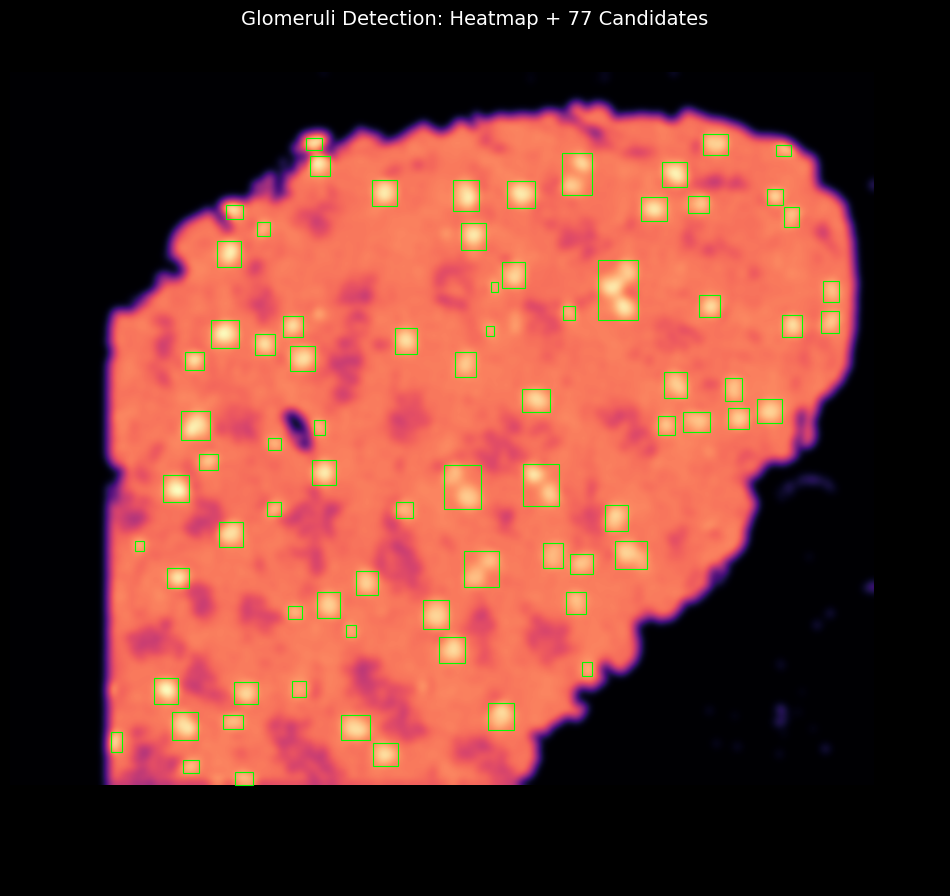

In [4]:
#!/usr/bin/env python3
# generate glomeruli candidates from visium expression data (with log1p)

import os
import json
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import StandardScaler
from scipy.ndimage import gaussian_filter, label, find_objects

# --- Your paths ---
VISIUM_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_visium_data/HUK1_COR1"
WHOLE_SLIDE_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_visium_data/HUK1_COR1/HUK1_COR_1.tif"

# --- Output ---
OUTDIR = "HUK1_COR1_out"
os.makedirs(OUTDIR, exist_ok=True)

# --- Heatmap / ROI parameters (meaningful knobs; no arbitrary K) ---
DOWN = 16.0          # level-0 pixels per heatmap pixel (bigger = smaller heatmap)
SIGMA = 6            # gaussian smoothing in heatmap pixels (bigger = larger blobs)
PCTL = 97            # keep top (100-PCTL)% of heatmap values as "glomerulus-like"
MIN_REGION_AREA = 50 # min connected-component area in heatmap pixels to keep (removes tiny noise)

# --- Marker sets (Human-style casing) ---
POD = ["NPHS1", "NPHS2", "PODXL", "WT1", "SYNPO", "PTPRO"]
ENDO = ["KDR", "EMCN", "PECAM1", "FLT1"]
TUB  = ["SLC34A1", "LRP2", "UMOD", "SLC12A1", "AQP2"]

# ---------------------------
# 1) Load Visium as AnnData
# ---------------------------
import squidpy as sq
import scanpy as sc

adata = sq.read.visium(VISIUM_PATH)

# Ensure unique var_names (fixes InvalidIndexError)
adata.var_names_make_unique()
if adata.raw is not None:
    adata.raw.var_names_make_unique()

# -------------------------------------------
# 1.5) Log transform (NO counts normalization)
# -------------------------------------------
# Keep raw counts if you want to inspect later
adata.layers["counts"] = adata.X.copy()

# log1p on adata.X (works with sparse too)
sc.pp.log1p(adata)

# Use logged values as "raw" for downstream scoring
# (so your _get_X uses adata.raw[:, genes].X consistently)
adata.raw = adata

# ---------------------------------------------------
# 3) Compute GlomScore from marker sets
# ---------------------------------------------------
def _get_X(adata, genes):
    genes = [g for g in genes if g in adata.var_names]
    if len(genes) == 0:
        return None, []
    X = adata.raw[:, genes].X if adata.raw is not None else adata[:, genes].X
    if sp.issparse(X):
        X = X.toarray()
    return X, genes

def zmean(adata, genes):
    X, used = _get_X(adata, genes)
    if X is None:
        return None, []
    # z-score each gene across spots, then average genes within the set
    Xz = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
    return Xz.mean(axis=1), used

pod_s, pod_used   = zmean(adata, POD)
endo_s, endo_used = zmean(adata, ENDO)
tub_s, tub_used   = zmean(adata, TUB)

score = np.zeros(adata.n_obs, dtype=np.float32)
pos_terms = 0

for s in [pod_s, endo_s]:
    if s is not None:
        score += s.astype(np.float32)
        pos_terms += 1

if pos_terms > 0:
    score /= pos_terms

if tub_s is not None:
    score -= tub_s.astype(np.float32)

adata.obs["GlomScore"] = score

print("Used genes:")
print("  pod :", pod_used)
print("  endo:", endo_used)
print("  tub :", tub_used)

if (pod_s is None) and (endo_s is None):
    raise RuntimeError(
        "No podocyte/endothelial genes were found in adata.var_names. "
        "Your var_names may be Ensembl IDs or different casing."
    )

# ---------------------------------------------------
# 4) Rasterize GlomScore into a grid + smooth
# ---------------------------------------------------
xy = adata.obsm["spatial"].astype(np.float32)
x = xy[:, 0]
y = xy[:, 1]
vals = adata.obs["GlomScore"].values.astype(np.float32)

xd = (x / DOWN).astype(np.int32)
yd = (y / DOWN).astype(np.int32)

W = int(xd.max() + 1)
H = int(yd.max() + 1)

acc = np.zeros((H, W), dtype=np.float32)
cnt = np.zeros((H, W), dtype=np.int32)

for xi, yi, v in zip(xd, yd, vals):
    if 0 <= yi < H and 0 <= xi < W:
        acc[yi, xi] += v
        cnt[yi, xi] += 1

grid = np.full((H, W), np.nan, dtype=np.float32)
mask = cnt > 0
grid[mask] = acc[mask] / cnt[mask]

minv = np.nanmin(grid)
grid_filled = np.where(np.isnan(grid), minv, grid)

heat = gaussian_filter(grid_filled, sigma=SIGMA)

# ---------------------------------------------------
# 5) Threshold + connected components (NO arbitrary K)
# ---------------------------------------------------
thr = np.percentile(heat, PCTL)
binary = heat > thr

lbl, ncomp = label(binary)
print(f"Connected components found: {ncomp} (before area filtering)")

slices = find_objects(lbl)

regions = []
for comp_id, slc in enumerate(slices, start=1):
    if slc is None:
        continue
    ys, xs = slc  # slices for y and x
    y0g, y1g = ys.start, ys.stop
    x0g, x1g = xs.start, xs.stop

    region_mask = (lbl[ys, xs] == comp_id)
    area = int(region_mask.sum())
    if area < MIN_REGION_AREA:
        continue

    # bbox in level-0 pixels
    x0 = float(x0g * DOWN)
    x1 = float(x1g * DOWN)
    y0 = float(y0g * DOWN)
    y1 = float(y1g * DOWN)

    # also store center
    xc = (x0 + x1) / 2.0
    yc = (y0 + y1) / 2.0

    regions.append({
        "id": len(regions),
        "x0": x0, "y0": y0, "x1": x1, "y1": y1,
        "x_center": xc, "y_center": yc,
        "area_gridpx": area,
        "threshold": float(thr),
        "percentile": float(PCTL),
        "down": float(DOWN),
        "sigma": float(SIGMA),
    })

print(f"Regions kept after area filter: {len(regions)}")

# ---------------------------------------------------
# 6) Export CSV + GeoJSON for QuPath
# ---------------------------------------------------
bbox_df = pd.DataFrame(regions)
csv_path = os.path.join(OUTDIR, "candidate_regions_bboxes_level0.csv")
bbox_df.to_csv(csv_path, index=False)
print("Wrote:", csv_path)

features = []
for r in regions:
    coords = [[
        [r["x0"], r["y0"]],
        [r["x1"], r["y0"]],
        [r["x1"], r["y1"]],
        [r["x0"], r["y1"]],
        [r["x0"], r["y0"]],
    ]]
    features.append({
        "type": "Feature",
        "geometry": {"type": "Polygon", "coordinates": coords},
        "properties": {
            "name": f"GlomRegion_{r['id']}",
            "id": int(r["id"]),
            "area_gridpx": int(r["area_gridpx"]),
            "pctl": float(PCTL),
        }
    })

geo = {"type": "FeatureCollection", "features": features}
geo_path = os.path.join(OUTDIR, "candidate_regions_bboxes_level0.geojson")
with open(geo_path, "w") as f:
    json.dump(geo, f)
print("Wrote:", geo_path)

print("\nNext: open the NDPI in QuPath, then import objects from:")
print(" ", geo_path)

# ---------------------------------------------------
# 7) Visualization: Heatmap + Boxes
# ---------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 'heat' is the smoothed grid (H, W).
# We set the extent so the heatmap pixels align with the level-0 box coordinates.
# Extent = [left, right, bottom, top] (Y is inverted for images)
h_grid, w_grid = heat.shape
extent = [0, w_grid * DOWN, h_grid * DOWN, 0]

fig, ax = plt.subplots(figsize=(12, 12), facecolor='black')

print("Plotting GlomScore Heatmap...")
im = ax.imshow(heat, extent=extent, cmap='magma', origin='upper', alpha=1.0)

print("Plotting Candidate Regions...")
for r in regions:
    w_box = r["x1"] - r["x0"]
    h_box = r["y1"] - r["y0"]
    rect = patches.Rectangle(
        (r["x0"], r["y0"]),
        w_box, h_box,
        linewidth=0.8,
        edgecolor='#00ff00',  # Bright Green
        facecolor='none'
    )
    ax.add_patch(rect)

ax.set_facecolor('black')
ax.set_axis_off()
ax.set_title(f"Glomeruli Detection: Heatmap + {len(regions)} Candidates", color='white', fontsize=14)

# Zoom to candidates
if regions:
    all_x = [r["x0"] for r in regions] + [r["x1"] for r in regions]
    all_y = [r["y0"] for r in regions] + [r["y1"] for r in regions]
    pad = 2000
    ax.set_xlim(min(all_x) - pad, max(all_x) + pad)
    ax.set_ylim(max(all_y) + pad, min(all_y) - pad)

vis_path = os.path.join(OUTDIR, "candidate_heatmap_preview.png")
plt.savefig(vis_path, dpi=150, facecolor='black', bbox_inches='tight')
print("Saved visualization to:", vis_path)
plt.show()


In [5]:
# check the bounding boxes generated from previous step and if there are more than 1 glomeruli in a bounding box, seperate them

import os, json
from scipy.ndimage import maximum_filter

REGION_CSV = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/HUK1_COR1_out/candidate_regions_bboxes_level0.csv"
OUTDIR = "HUK1_COR1_out"
os.makedirs(OUTDIR, exist_ok=True)

# --- Split parameters ---
PCTL = 97.5
MIN_SPLIT_DIST_PX = 100

MIN_SUB_BOX = 600
MAX_SUB_BOX = 1200
SUB_FRAC = 0.60

MAX_CHILDREN = 3
CLAMP_TO_PARENT = True

def clamp_int(v, lo, hi):
    return max(lo, min(hi, int(v)))

def to_geojson(df, out_path, name_prefix="Split"):
    feats = []
    for r in df.itertuples(index=False):
        coords = [[
            [float(r.x0), float(r.y0)],
            [float(r.x1), float(r.y0)],
            [float(r.x1), float(r.y1)],
            [float(r.x0), float(r.y1)],
            [float(r.x0), float(r.y0)],
        ]]
        props = {
            "name": f"{name_prefix}_{int(r.id)}",
            "id": int(r.id),
            "parent_id": int(r.parent_id),
            "peak_rank": int(r.peak_rank),
            "heat_value": float(r.heat_value),
        }
        feats.append({"type":"Feature","geometry":{"type":"Polygon","coordinates":coords},"properties":props})
    with open(out_path, "w") as f:
        json.dump({"type":"FeatureCollection","features":feats}, f)

def split_region_maxN(heat, DOWN, region_box, thr_global, min_split_dist_px, max_children=3):
    """Return 1..max_children peak centers inside region_box based on local maxima in heat."""
    H, W = heat.shape

    x0g = int(np.floor(region_box["x0"] / DOWN))
    x1g = int(np.ceil (region_box["x1"] / DOWN))
    y0g = int(np.floor(region_box["y0"] / DOWN))
    y1g = int(np.ceil (region_box["y1"] / DOWN))

    x0g = clamp_int(x0g, 0, W-1)
    x1g = clamp_int(x1g, 1, W)
    y0g = clamp_int(y0g, 0, H-1)
    y1g = clamp_int(y1g, 1, H)

    if x1g <= x0g or y1g <= y0g:
        cx = (region_box["x0"] + region_box["x1"]) / 2.0
        cy = (region_box["y0"] + region_box["y1"]) / 2.0
        return [{"peak_rank": 1, "xc": cx, "yc": cy, "heat_value": float("nan")}]

    patch = heat[y0g:y1g, x0g:x1g]

    min_dist_grid = max(3, int(min_split_dist_px / DOWN))
    mx = maximum_filter(patch, size=(2 * min_dist_grid + 1))
    cand = (patch == mx) & (patch >= thr_global)
    peaks = np.argwhere(cand)

    if len(peaks) == 0:
        py, px = np.unravel_index(np.argmax(patch), patch.shape)
        gy, gx = y0g + py, x0g + px
        hv = float(heat[gy, gx])
        xc = (gx + 0.5) * DOWN
        yc = (gy + 0.5) * DOWN
        return [{"peak_rank": 1, "xc": xc, "yc": yc, "heat_value": hv}]

    peak_list = []
    for py, px in peaks:
        gy, gx = y0g + int(py), x0g + int(px)
        hv = float(heat[gy, gx])
        peak_list.append((gy, gx, hv))
    peak_list.sort(key=lambda t: -t[2])

    chosen = []

    def far_enough(candidate, chosen_list):
        # candidate: (gy,gx,hv)
        for (cy, cx, _) in chosen_list:
            d_px = np.hypot((candidate[1] - cx) * DOWN, (candidate[0] - cy) * DOWN)
            if d_px < min_split_dist_px:
                return False
        return True

    for p in peak_list:
        if len(chosen) == 0:
            chosen.append(p)
        else:
            if far_enough(p, chosen):
                chosen.append(p)
        if len(chosen) >= max_children:
            break

    out = []
    for rank, (gy, gx, hv) in enumerate(chosen, start=1):
        xc = (gx + 0.5) * DOWN
        yc = (gy + 0.5) * DOWN
        out.append({"peak_rank": rank, "xc": xc, "yc": yc, "heat_value": float(hv)})
    return out

# ---- Run over all regions ----
regions = pd.read_csv(REGION_CSV)
for c in ["x0","y0","x1","y1"]:
    if c not in regions.columns:
        raise ValueError(f"Region CSV must include x0,y0,x1,y1. Got: {regions.columns.tolist()}")

if "id" not in regions.columns:
    regions = regions.reset_index().rename(columns={"index":"id"})

thr_global = np.percentile(heat, PCTL)

rows = []
new_id = 0

for r in regions.itertuples(index=False):
    parent_id = int(r.id)
    reg = {"x0": float(r.x0), "y0": float(r.y0), "x1": float(r.x1), "y1": float(r.y1)}

    peaks = split_region_maxN(
        heat=heat,
        DOWN=DOWN,
        region_box=reg,
        thr_global=thr_global,
        min_split_dist_px=MIN_SPLIT_DIST_PX,
        max_children=MAX_CHILDREN
    )

    # Adaptive sub-box sizing based on parent region
    parent_w = float(r.x1) - float(r.x0)
    parent_h = float(r.y1) - float(r.y0)
    parent_side = min(parent_w, parent_h)

    sub_side = SUB_FRAC * parent_side
    sub_side = max(MIN_SUB_BOX, min(MAX_SUB_BOX, sub_side))
    half = sub_side / 2.0

    for p in peaks:
        xc, yc = float(p["xc"]), float(p["yc"])

        x0 = xc - half; y0 = yc - half
        x1 = xc + half; y1 = yc + half

        if CLAMP_TO_PARENT:
            x0 = max(x0, float(r.x0)); y0 = max(y0, float(r.y0))
            x1 = min(x1, float(r.x1)); y1 = min(y1, float(r.y1))

        rows.append([new_id, parent_id, int(p["peak_rank"]), xc, yc, x0, y0, x1, y1, float(p["heat_value"])])
        new_id += 1

split_df = pd.DataFrame(
    rows,
    columns=["id","parent_id","peak_rank","x_center","y_center","x0","y0","x1","y1","heat_value"]
)

csv_out = os.path.join(OUTDIR, "region_split_max3.csv")
split_df.to_csv(csv_out, index=False)
print("Wrote:", csv_out, "n=", len(split_df))

geo_out = os.path.join(OUTDIR, "region_split_max3.geojson")
to_geojson(split_df, geo_out, name_prefix="STsplit")
print("Wrote:", geo_out)
print("QuPath: File → Import objects →", geo_out)


Wrote: HUK1_COR1_out/region_split_max3.csv n= 83
Wrote: HUK1_COR1_out/region_split_max3.geojson
QuPath: File → Import objects → HUK1_COR1_out/region_split_max3.geojson


Manually labeled glomeruli bounding box images using the label_glomeruli_app.py script and trained linear dinov2 classifier with train_glom_dinov2_linear.py to predict if glomeruli bounding box images are truely glomeruli or not.

In [9]:
# manual glomeruli bounding box label counts
import pandas as pd

LABELS_CSV = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/box_labels.csv"
df = pd.read_csv(LABELS_CSV)

print(df["label"].value_counts(dropna=False))
print("\nMulti-glom counts:")
print(df["multi"].value_counts(dropna=False))

label
not_glomerulus    148
glomerulus        124
Name: count, dtype: int64

Multi-glom counts:
multi
False    272
Name: count, dtype: int64


In [10]:
# open bounding boxes around glomeruli using openslide and score them using a the trained model to keep only glomeruli

import os, json
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
import openslide

# -----------------------
# Paths (EDIT if needed)
# -----------------------
NDPI_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_kidney_data_ndpi/OTS-24-22043 - 2024-08-28 15.08.37.ndpi"
BOXES_CSV = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/region_split_max3.csv"
CKPT_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/glom_dinov2_linear.pt"
OUTDIR = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out"
os.makedirs(OUTDIR, exist_ok=True)

OUT_SCORES = os.path.join(OUTDIR, "box_scores.csv")
OUT_GEOJSON = os.path.join(OUTDIR, "high_conf_glomeruli.geojson")

# -----------------------
# Settings
# -----------------------
FINAL_IMG_SIZE = 224
PAD_FRAC = 0.05
TARGET_VIEW_PX = 900

# Choose threshold
THRESH = 0.40  # start high; you can lower to 0.7 if you want more candidates

# Batch size for inference
BATCH = 64

# -----------------------
# Helpers
# -----------------------
def expand_box(x0, y0, x1, y1, pad_frac):
    w = x1 - x0
    h = y1 - y0
    px = int(round(w * pad_frac))
    py = int(round(h * pad_frac))
    return x0 - px, y0 - py, x1 + px, y1 + py

def clamp_box(x0, y0, x1, y1, W, H):
    x0 = max(0, min(W, int(round(x0))))
    y0 = max(0, min(H, int(round(y0))))
    x1 = max(0, min(W, int(round(x1))))
    y1 = max(0, min(H, int(round(y1))))
    if x1 <= x0: x1 = min(W, x0 + 1)
    if y1 <= y0: y1 = min(H, y0 + 1)
    return x0, y0, x1, y1

def read_crop(slide, x0, y0, x1, y1, target_view_px=900):
    W0, H0 = slide.dimensions
    x0, y0, x1, y1 = clamp_box(x0, y0, x1, y1, W0, H0)
    w = x1 - x0
    h = y1 - y0

    want_down = max(w, h) / float(target_view_px)
    level = slide.get_best_level_for_downsample(want_down)
    down = float(slide.level_downsamples[level])

    x0_l = int(x0 / down)
    y0_l = int(y0 / down)
    w_l  = max(1, int(w / down))
    h_l  = max(1, int(h / down))

    img = slide.read_region((x0_l, y0_l), level, (w_l, h_l)).convert("RGB")
    return img

def to_geojson(df, out_path, name_prefix="PredGlom"):
    feats = []
    for r in df.itertuples(index=False):
        coords = [[
            [float(r.x0), float(r.y0)],
            [float(r.x1), float(r.y0)],
            [float(r.x1), float(r.y1)],
            [float(r.x0), float(r.y1)],
            [float(r.x0), float(r.y0)],
        ]]
        props = {
            "name": f"{name_prefix}_{int(r.id)}",
            "id": int(r.id),
            "p_glom": float(r.p_glom),
        }
        if "parent_id" in df.columns:
            props["parent_id"] = int(getattr(r, "parent_id"))
        if "peak_rank" in df.columns:
            props["peak_rank"] = int(getattr(r, "peak_rank"))
        feats.append({"type":"Feature","geometry":{"type":"Polygon","coordinates":coords},"properties":props})
    with open(out_path, "w") as f:
        json.dump({"type":"FeatureCollection","features":feats}, f)

# -----------------------
# Device
# -----------------------
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------
# Load model
# -----------------------
ckpt = torch.load(CKPT_PATH, map_location="cpu")
backbone_name = ckpt.get("backbone", "dinov2_vits14")
emb_dim = int(ckpt.get("emb_dim", 384))

backbone = torch.hub.load("facebookresearch/dinov2", backbone_name)
backbone.eval().to(device)
for p in backbone.parameters():
    p.requires_grad = False

head = torch.nn.Linear(emb_dim, 1)
head.load_state_dict(ckpt["head_state"])
head.eval().to(device)

# -----------------------
# Transforms
# -----------------------
tfm = transforms.Compose([
    transforms.Resize(FINAL_IMG_SIZE, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(FINAL_IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

# -----------------------
# Load slide + boxes
# -----------------------
slide = openslide.OpenSlide(NDPI_PATH)
boxes = pd.read_csv(BOXES_CSV)
if "id" not in boxes.columns:
    boxes = boxes.reset_index().rename(columns={"index":"id"})
boxes["id"] = boxes["id"].astype(int)

# Ensure coords float
for c in ["x0","y0","x1","y1"]:
    boxes[c] = boxes[c].astype(float)

# -----------------------
# Score all boxes
# -----------------------
probs = []
ids = []

batch_imgs = []
batch_ids = []
batch_rows = []

with torch.no_grad():
    for i, r in boxes.iterrows():
        x0, y0, x1, y1 = float(r.x0), float(r.y0), float(r.x1), float(r.y1)
        x0, y0, x1, y1 = expand_box(x0, y0, x1, y1, PAD_FRAC)

        img = read_crop(slide, x0, y0, x1, y1, target_view_px=TARGET_VIEW_PX)
        x = tfm(img)  # tensor C,H,W

        batch_imgs.append(x)
        batch_ids.append(int(r.id))
        batch_rows.append(i)

        if len(batch_imgs) >= BATCH:
            xb = torch.stack(batch_imgs, dim=0).to(device)
            z = backbone(xb)
            logits = head(z).squeeze(1)
            p = torch.sigmoid(logits).detach().cpu().numpy()

            probs.extend(p.tolist())
            ids.extend(batch_ids)

            batch_imgs, batch_ids, batch_rows = [], [], []

    # leftover
    if len(batch_imgs) > 0:
        xb = torch.stack(batch_imgs, dim=0).to(device)
        z = backbone(xb)
        logits = head(z).squeeze(1)
        p = torch.sigmoid(logits).detach().cpu().numpy()

        probs.extend(p.tolist())
        ids.extend(batch_ids)

scores = pd.DataFrame({"id": ids, "p_glom": probs})
out = boxes.merge(scores, on="id", how="left")
out.to_csv(OUT_SCORES, index=False)
print("Wrote:", OUT_SCORES)

hi = out[out["p_glom"] >= THRESH].copy().sort_values("p_glom", ascending=False)
to_geojson(hi, OUT_GEOJSON, name_prefix="PredGlom")
print("Wrote:", OUT_GEOJSON, "n=", len(hi))
print("QuPath: File → Import objects →", OUT_GEOJSON)


Device: mps


Using cache found in /Users/edmundtsou/.cache/torch/hub/facebookresearch_dinov2_main
/Users/edmundtsou/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/edmundtsou/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/edmundtsou/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Wrote: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/box_scores.csv
Wrote: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/high_conf_glomeruli.geojson n= 131
QuPath: File → Import objects → /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/high_conf_glomeruli.geojson


In [ ]:
"""
End-to-end Glomerulus Segmentation with:
  - GeoJSON polygons → padded patch crops from NDPI (OpenSlide)
  - 3 heuristic priors (hematoxylin nuclei density, texture, white/lumen)
  - SAM prompts: box + points
  - Mask selection by IoU to prior (not SAM score)
  - Runs for EVERY feature in the GeoJSON

Notes:
  - Expects your SAM checkpoint is already downloaded locally.
  - Designed for Colab + Google Drive paths, but works anywhere if paths are valid.
"""

# ============================================================
# 0) Imports
# ============================================================
import os, json
import numpy as np
import cv2
import torch
import openslide
import matplotlib.pyplot as plt

from skimage.color import rgb2hed
from scipy.ndimage import binary_fill_holes

from segment_anything import sam_model_registry, SamPredictor


# ============================================================
# 1) User-configurable paths & parameters
# ============================================================
# --- input ---
GEOJSON_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/high_conf_glomeruli.geojson"
NDPI_PATH    = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_kidney_data_ndpi/OTS-24-22043 - 2024-08-28 15.08.37.ndpi"

# --- SAM checkpoint (already downloaded) ---
SAM_MODEL_TYPE = "vit_b"  # "vit_h" / "vit_l" / "vit_b"
SAM_CKPT_PATH  = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/checkpoints/best_dice_checkpoint.pth" 

# --- output ---
OUTDIR = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out_sam_adapt"

os.makedirs(OUTDIR, exist_ok=True)

# --- patch crop ---
PADDING_PX = 200

# --- priors ---
RADIUS_PX = 160           # hematoxylin density circle radius
CENTER_WEIGHT = 1.0       # 0 disables center bias; >0 biases toward center
TEXTURE_PCT = 85          # percentile threshold for texture map
MIN_NONEMPTY = 200        # fallback threshold if soft intersection too small

# --- point sampling ---
N_POS = 2
N_NEG = 2

# --- morphology ---
ERODE_INTERIOR_K = 9
DILATE_SOFTI_K = 11

# --- debugging / visualization ---
SAVE_DEBUG_PNG = True     # saves patch + overlay + priors for each feature
SHOW_PLOTS = False        # if True, calls plt.show() (slow for many features)

KEEP_ONLY_LARGEST_POLYGON = False   # True = keep only the biggest polygon per feature
MIN_POLY_AREA_PX = 200              # ignore tiny contour fragments


# ============================================================
# 2) Small utilities (connected components + morphology)
# ============================================================
def keep_largest_component(mask, prefer_center=True):
    """Keep the best connected component (by area, optionally center-biased)."""
    mask = mask.astype(np.uint8)
    num, lab = cv2.connectedComponents(mask)
    if num <= 1:
        return mask.astype(bool)

    H, W = mask.shape
    cx, cy = W / 2.0, H / 2.0

    best_i, best_score = None, -1e18
    for i in range(1, num):
        comp = (lab == i)
        area = int(comp.sum())
        if area < 50:
            continue

        if prefer_center:
            ys, xs = np.where(comp)
            mx, my = xs.mean(), ys.mean()
            dist2 = (mx - cx) ** 2 + (my - cy) ** 2
            score = area - 0.001 * dist2
        else:
            score = area

        if score > best_score:
            best_score, best_i = score, i

    if best_i is None:
        return np.zeros_like(mask, dtype=bool)

    return (lab == best_i)


def clean_mask(mask, close_ks=9, open_ks=5, fill=True):
    """Close/open + optionally fill holes."""
    m = (mask.astype(np.uint8) * 255)
    if close_ks:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
    if open_ks:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k)

    m = (m > 0)
    if fill:
        m = binary_fill_holes(m)

    return m


def dilate(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    return cv2.dilate(mask.astype(np.uint8) * 255, kk) > 0


def erode(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    return cv2.erode(mask.astype(np.uint8) * 255, kk) > 0


def safe_bbox_from_mask(mask_bool, fallback_to_full=True):
    """Return (x0,y0,x1,y1) from a boolean mask; safe fallback if empty."""
    ys, xs = np.where(mask_bool)
    if len(xs) == 0 or len(ys) == 0:
        if not fallback_to_full:
            return None
        H, W = mask_bool.shape
        return (0, 0, W - 1, H - 1)
    x0, x1 = int(xs.min()), int(xs.max())
    y0, y1 = int(ys.min()), int(ys.max())
    return (x0, y0, x1, y1)

def keep_component_containing_points(mask_bool, point_coords, point_labels, label_val=1, fallback="largest"):
    """
    Keep only connected component(s) of mask_bool that contain at least one positive point.
    fallback: "largest" or "none"
    """
    m = mask_bool.astype(np.uint8)
    num, lab = cv2.connectedComponents(m, connectivity=8)
    if num <= 2:  # 0=bg, 1=only fg (or empty)
        return mask_bool.astype(bool)

    keep_labels = set()
    if point_coords is not None and point_labels is not None:
        for (x, y), l in zip(point_coords, point_labels):
            if int(l) != int(label_val):
                continue
            xi, yi = int(round(float(x))), int(round(float(y)))
            if 0 <= yi < lab.shape[0] and 0 <= xi < lab.shape[1]:
                lbl = int(lab[yi, xi])
                if lbl != 0:
                    keep_labels.add(lbl)

    if not keep_labels:
        if fallback == "largest":
            areas = [(lab == i).sum() for i in range(1, num)]
            keep = 1 + int(np.argmax(areas))
            return (lab == keep)
        return np.zeros_like(mask_bool, dtype=bool)

    out = np.zeros_like(mask_bool, dtype=bool)
    for lbl in keep_labels:
        out |= (lab == lbl)
    return out

# ============================================================
# 3) Prior #1: Hematoxylin nuclei density circle (debuggable)
# ============================================================
def mask_from_hematoxylin_density_circle(
    img_rgb,
    sigma_nuc=1.5,
    radius_px=80,
    center_weight=2.0,
    show=False,
):
    """
    Steps:
      1) HED deconvolution → hematoxylin channel → nuclei intensity map
      2) Otsu threshold → nuclei binary
      3) Convolve with circular kernel → nuclei-count-in-circle density map
      4) Pick global max (optionally center-biased)
      5) Output a circle mask at that max
    """
    # --- HED → H channel ---
    hed = rgb2hed(img_rgb)
    H = hed[:, :, 0]
    Hn = (H - H.min()) / (H.max() - H.min() + 1e-8)
    nuclei = 1.0 - Hn  # nuclei bright

    # --- Otsu on blurred nuclei map ---
    nuclei8 = (nuclei * 255).astype(np.uint8)
    nuclei8b = cv2.GaussianBlur(nuclei8, (0, 0), sigma_nuc)
    _, bw = cv2.threshold(nuclei8b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # In your earlier code you used (bw == 0) as foreground.
    # Keep same behavior for consistency:
    bw01 = (bw == 0).astype(np.float32)

    # --- circular kernel convolution ---
    r = int(radius_px)
    yy, xx = np.ogrid[-r : r + 1, -r : r + 1]
    kernel = ((xx * xx + yy * yy) <= r * r).astype(np.float32)
    dens = cv2.filter2D(bw01, -1, kernel, borderType=cv2.BORDER_CONSTANT)

    # --- optional center bias ---
    score = dens.copy()
    if center_weight > 0:
        Hh, Ww = score.shape
        cx0, cy0 = Ww / 2.0, Hh / 2.0
        Y, X = np.mgrid[0:Hh, 0:Ww]
        r2 = ((X - cx0) ** 2 + (Y - cy0) ** 2) / ((0.5 * min(Hh, Ww)) ** 2 + 1e-8)
        w = np.exp(-center_weight * r2)
        score *= w

    # --- max location ---
    cy, cx = np.unravel_index(np.argmax(score), score.shape)

    # --- circle mask ---
    Y, X = np.mgrid[0:score.shape[0], 0:score.shape[1]]
    circle = ((X - cx) ** 2 + (Y - cy) ** 2) <= (r * r)
    m_bool = circle.astype(bool)

    if show:
        dens_norm = dens / (dens.max() + 1e-8)
        overlay = img_rgb.copy()
        cv2.circle(overlay, (int(cx), int(cy)), r, (255, 0, 0), 2)
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 3, 1); plt.title("Otsu nuclei mask"); plt.imshow(bw, cmap="gray"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.title("Density (norm)"); plt.imshow(dens_norm, cmap="gray"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.title("Circle overlay"); plt.imshow(overlay); plt.axis("off")
        plt.show()

    return m_bool, (int(cx), int(cy)), dens


# ============================================================
# 4) Prior #2: Texture variance mask
# ============================================================
def mask_from_texture(img_rgb,
                      var_sigma=2,          # local variance blur scale
                      smooth_sigma=3,       # smooth the variance map before threshold
                      thr_percentile=85,    # threshold on weighted texture
                      center_weight=2.0,    # 0 = no bias; bigger = stronger center bias
                      center_radius_frac=0.55,  # controls how wide the center "sweet spot" is
                      close_ks=13, open_ks=7, fill=True):
    """
    Texture prior with optional center bias:
    - Compute local variance texture map (varn in 0..1)
    - Apply a smooth center weighting w(x,y) in (0..1)
    - Threshold weighted texture, then clean + keep largest component
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    # --- local variance ---
    mu  = cv2.GaussianBlur(gray, (0, 0), var_sigma)
    mu2 = cv2.GaussianBlur(gray * gray, (0, 0), var_sigma)
    var = np.clip(mu2 - mu * mu, 0, None)

    # normalize 0..1
    varn = (var - var.min()) / (var.max() - var.min() + 1e-8)

    # smooth a bit
    v8 = (varn * 255).astype(np.uint8)
    v8 = cv2.GaussianBlur(v8, (0, 0), smooth_sigma)
    varn_smooth = v8.astype(np.float32) / 255.0

    # --- center bias weight map ---
    if center_weight > 0:
        H, W = varn_smooth.shape
        cy, cx = (H - 1) / 2.0, (W - 1) / 2.0
        Y, X = np.mgrid[0:H, 0:W]

        # normalized squared radius: 0 at center, ~1 near "center_radius_frac" of min dim
        denom = (center_radius_frac * min(H, W)) ** 2 + 1e-8
        r2 = ((X - cx) ** 2 + (Y - cy) ** 2) / denom

        # gaussian-like weight: exp(-center_weight * r2)
        w = np.exp(-center_weight * r2).astype(np.float32)

        score = varn_smooth * w
    else:
        score = varn_smooth

    # --- threshold on weighted score (more robust than Otsu here) ---
    thr = np.percentile(score, thr_percentile)
    m = score >= thr

    # --- cleanup ---
    m = clean_mask(m, close_ks=close_ks, open_ks=open_ks, fill=fill)
    m = keep_largest_component(m, prefer_center=True)
    return m


# ============================================================
# 5) Prior #3: White/lumen-based mask
# ============================================================
def mask_from_white_lumen(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    S = hsv[:, :, 1]
    V = hsv[:, :, 2]
    white = ((V > 200) & (S < 60))

    # invert → "tissue mass" (non-white)
    m = ~white
    m = clean_mask(m, close_ks=9, open_ks=5, fill=True)
    m = keep_largest_component(m, prefer_center=True)
    return m


# ============================================================
# 6) Build consensus priors (majority + soft intersection)
# ============================================================
def build_priors(img_rgb):
    mH, _, _ = mask_from_hematoxylin_density_circle(
        img_rgb,
        radius_px=RADIUS_PX,
        center_weight=CENTER_WEIGHT,
        show=False,
    )
    mT = mask_from_texture(img_rgb, pct=TEXTURE_PCT)
    mW = mask_from_white_lumen(img_rgb)

    # majority vote
    vote = mH.astype(np.uint8) + mT.astype(np.uint8) + mW.astype(np.uint8)
    m_major = (vote >= 2)
    m_major = clean_mask(m_major, close_ks=11, open_ks=5, fill=True)
    m_major = keep_largest_component(m_major, prefer_center=True)

    # soft intersection (dilate each then AND)
    m_softI = dilate(mH, DILATE_SOFTI_K) & dilate(mT, DILATE_SOFTI_K) & dilate(mW, DILATE_SOFTI_K)
    m_softI = clean_mask(m_softI, close_ks=9, open_ks=5, fill=True)
    m_softI = keep_largest_component(m_softI, prefer_center=True)

    if int(m_softI.sum()) < MIN_NONEMPTY:
        m_softI = m_major

    # interior for positive points
    interior = erode(m_softI, ERODE_INTERIOR_K)
    if int(interior.sum()) < 50:
        interior = m_softI

    return mH, mT, mW, m_major, m_softI, interior


# ============================================================
# 7) Point sampling for SAM (pos inside interior, neg outside coarse)
# ============================================================
def sample_points(interior_mask, coarse_mask, n_pos=16, n_neg=2):
    # positive points from interior
    ys, xs = np.where(interior_mask)
    if len(xs) == 0:
        return None, None

    n_pos_eff = min(n_pos, len(xs))
    idx = np.random.choice(len(xs), n_pos_eff, replace=False)
    pos = list(zip(xs[idx], ys[idx]))

    # negative points from outside coarse
    neg_mask = ~coarse_mask
    ys, xs = np.where(neg_mask)
    n_neg_eff = min(n_neg, len(xs))
    idx = np.random.choice(len(xs), n_neg_eff, replace=False)
    neg = list(zip(xs[idx], ys[idx]))

    pts = np.array(pos + neg, dtype=np.float32)
    labels = np.array([1] * len(pos) + [0] * len(neg), dtype=np.int32)
    return pts, labels


# ============================================================
# 8) SAM wrapper: predict with box + points, choose best by IoU-to-prior
# ============================================================
def iou(a, b):
    a = a.astype(bool)
    b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(inter) / (float(uni) + 1e-8)


def run_sam_on_patch(predictor, patch_np, prior_mask, interior_mask, coarse_for_neg):
    """
    Builds:
      - box from prior_mask (or coarse)
      - points from interior (pos) and outside coarse_for_neg (neg)
    Runs SAM and returns best mask (by IoU to prior_mask).
    """
    predictor.set_image(patch_np)

    # points
    if interior_mask is not None and int(interior_mask.sum()) > 0:
        point_coords, point_labels = sample_points(interior_mask, coarse_for_neg, n_pos=N_POS, n_neg=N_NEG)
    else:
        H, W = patch_np.shape[:2]
        point_coords = np.array([[W / 2, H / 2]], dtype=np.float32)
        point_labels = np.array([1], dtype=np.int32)
    bbox = safe_bbox_from_mask(prior_mask, fallback_to_full=True)
    x0, y0, x1, y1 = bbox
    box = np.array([x0, y0, x1, y1], dtype=np.float32)

    masks, scores, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        box=box[None, :],
        multimask_output=True,
    )

    # choose by IoU to prior
    ious = [iou(m, prior_mask) for m in masks]
    best = int(np.argmax(ious))
    best_mask = masks[best]
    

    return best_mask, scores, ious, (point_coords, point_labels), (x0, y0, x1, y1), best


# ============================================================
# 9) GeoJSON → patch crop utilities
# ============================================================
def feature_bbox_from_geojson(feature):
    """Extract bbox (min_x,min_y,max_x,max_y) from polygon coords in a GeoJSON feature."""
    coords = np.array(feature["geometry"]["coordinates"][0], dtype=np.float32)
    min_x = int(np.floor(coords[:, 0].min()))
    min_y = int(np.floor(coords[:, 1].min()))
    max_x = int(np.ceil(coords[:, 0].max()))
    max_y = int(np.ceil(coords[:, 1].max()))
    return min_x, min_y, max_x, max_y


def read_padded_patch(slide, bbox_xyxy, padding_px):
    """Read padded patch from OpenSlide at level 0."""
    min_x, min_y, max_x, max_y = bbox_xyxy
    min_xp = max(0, min_x - padding_px)
    min_yp = max(0, min_y - padding_px)

    w = (max_x + padding_px) - min_xp
    h = (max_y + padding_px) - min_yp

    patch = slide.read_region((min_xp, min_yp), 0, (w, h)).convert("RGB")
    patch_np = np.asarray(patch, dtype=np.uint8)
    return patch_np, (min_xp, min_yp, w, h)


# ============================================================
# 10) Save helpers (mask PNG + debug figure + optional polygon GeoJSON)
# ============================================================
def _ensure_polygon_closed(coords):
    if len(coords) >= 2 and coords[0] != coords[-1]:
        coords = coords + [coords[0]]
    return coords

def mask_to_polygon_features(mask_bool, offset_xy=(0, 0), min_area=100, props=None):
    """
    Convert a boolean mask to a list of GeoJSON Feature polygons (external contours),
    mapped back to slide coordinates via offset_xy.
    """
    if props is None:
        props = {}

    xoff, yoff = offset_xy
    m = (mask_bool.astype(np.uint8) * 255)
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    feats = []
    for c in contours:
        area = float(cv2.contourArea(c))
        if area < float(min_area):
            continue

        c = c.squeeze(1)  # (N,2)
        if c.ndim != 2 or c.shape[0] < 3:
            continue

        ring = [[float(xoff + p[0]), float(yoff + p[1])] for p in c]
        ring = _ensure_polygon_closed(ring)

        feats.append({
            "type": "Feature",
            "properties": {**props, "area_px": area},
            "geometry": {"type": "Polygon", "coordinates": [ring]},
        })
    return feats

def save_debug_figure(patch_np, mH, mT, mW, m_major, m_softI, sam_mask,
                      point_coords, point_labels, box_xyxy, out_path, title=""):
    x0, y0, x1, y1 = box_xyxy

    plt.figure(figsize=(16, 10))
    plt.suptitle(title)

    plt.subplot(2, 4, 1); plt.title("Patch"); plt.imshow(patch_np); plt.axis("off")
    plt.subplot(2, 4, 2); plt.title("mH (hematoxylin)"); plt.imshow(mH, cmap="gray"); plt.axis("off")
    plt.subplot(2, 4, 3); plt.title("mT (texture)"); plt.imshow(mT, cmap="gray"); plt.axis("off")
    plt.subplot(2, 4, 4); plt.title("mW (white/lumen)"); plt.imshow(mW, cmap="gray"); plt.axis("off")

    plt.subplot(2, 4, 5); plt.title("m_major"); plt.imshow(m_major, cmap="gray"); plt.axis("off")
    plt.subplot(2, 4, 6); plt.title("m_softI"); plt.imshow(m_softI, cmap="gray"); plt.axis("off")

    # overlay SAM
    ax = plt.subplot(2, 4, 7)
    ax.set_title("SAM overlay (box + points)")
    ax.imshow(patch_np)
    ax.imshow(sam_mask, alpha=0.45, cmap="Blues")
    # points
    ax.scatter(
        point_coords[:, 0], point_coords[:, 1],
        c=["lime" if l == 1 else "red" for l in point_labels],
        s=25,
    )
    # box
    ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor="yellow", linewidth=2))
    ax.axis("off")

    plt.subplot(2, 4, 8); plt.title("SAM mask"); plt.imshow(sam_mask, cmap="gray"); plt.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    if SHOW_PLOTS:
        plt.show()
    plt.close()


# ============================================================
# 11) Main loop: run for every GeoJSON feature
# ============================================================
def main():
    # ----------------------------
    # 0) Load GeoJSON
    # ----------------------------
    with open(GEOJSON_PATH, "r") as f:
        geo = json.load(f)
    features = geo.get("features", [])
    print(f"Loaded {len(features)} GeoJSON features from: {GEOJSON_PATH}")

    # ----------------------------
    # 1) Open slide
    # ----------------------------
    slide = openslide.OpenSlide(NDPI_PATH)
    print(f"Opened slide: {NDPI_PATH}")
    print(f"Slide level-0 dims: {slide.dimensions}")

    # ----------------------------
    # 2) Load SAM (checkpoint already downloaded)
    # ----------------------------
    assert os.path.exists(SAM_CKPT_PATH), f"SAM checkpoint not found: {SAM_CKPT_PATH}"

    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"

    sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CKPT_PATH)
    sam.to(device)
    predictor = SamPredictor(sam)
    print(f"SAM loaded: {SAM_MODEL_TYPE} on {device}")
    print(f"Outputs → {OUTDIR}")

    # ----------------------------
    # 3) Outputs dirs
    # ----------------------------
    out_masks_dir = os.path.join(OUTDIR, "masks_png")
    out_dbg_dir   = os.path.join(OUTDIR, "debug_png")
    out_geo_dir   = os.path.join(OUTDIR, "sam_polygons_geojson")
    os.makedirs(out_masks_dir, exist_ok=True)
    os.makedirs(out_dbg_dir, exist_ok=True)
    os.makedirs(out_geo_dir, exist_ok=True)

    # ----------------------------
    # 4) Run over all features
    # ----------------------------
    results = []
    merged_features = []

    for i, feat in enumerate(features):
        try:
            # ----------------------------
            # A) Crop patch around feature bbox (padded)
            # ----------------------------
            bbox = feature_bbox_from_geojson(feat)  # (minx,miny,maxx,maxy) in slide coords
            patch_np, (px, py, pw, ph) = read_padded_patch(slide, bbox, PADDING_PX)

            # ----------------------------
            # B) Build priors on patch
            # ----------------------------
            mH, mT, mW, m_major, m_softI, interior = build_priors(patch_np)

            # ----------------------------
            # C) Run SAM with box + points
            # ----------------------------
            sam_mask, sam_scores, sam_ious, (pcoords, plabels), box_xyxy, best_idx = run_sam_on_patch(
                predictor=predictor,
                patch_np=patch_np,
                prior_mask=m_major,          # IoU reference prior
                interior_mask=interior,      # positive points from interior
                coarse_for_neg=m_major,      # negatives sampled outside this
            )

            sam_mask = keep_component_containing_points(
                sam_mask,
                pcoords,
                plabels,
                label_val=1,
                fallback="largest",   # if no positive points land inside, keep largest component
            )

            sam_mask = clean_mask(sam_mask, close_ks=7, open_ks=0, fill=True)


            # ----------------------------
            # D) Save outputs (mask + per-feature geojson + debug)
            # ----------------------------
            base = f"feat_{i:05d}"
            mask_png_path = os.path.join(out_masks_dir, base + "_sam_mask.png")
            dbg_png_path  = os.path.join(out_dbg_dir,   base + "_debug.png")
            geo_out_path  = os.path.join(out_geo_dir,   base + "_sam_polys.geojson")

            save_mask_png(sam_mask, mask_png_path)

            # Convert mask to polygons in SLIDE coordinates (offset by patch origin)
            props = {
                "source_feature_index": int(i),
                "patch_origin_x": int(px),
                "patch_origin_y": int(py),
                "patch_w": int(pw),
                "patch_h": int(ph),
                "sam_best_idx": int(best_idx),
                "sam_best_score": float(sam_scores[best_idx]),
                "sam_best_iou_to_prior": float(sam_ious[best_idx]),
            }

            sam_poly_feats = mask_to_polygon_features(
                sam_mask,
                offset_xy=(px, py),
                min_area=MIN_POLY_AREA_PX if "MIN_POLY_AREA_PX" in globals() else 200,
                props=props,
            )

            # OPTIONAL: keep only the largest polygon per input feature
            if KEEP_ONLY_LARGEST_POLYGON:
                if len(sam_poly_feats) > 0:
                    sam_poly_feats = [max(sam_poly_feats, key=lambda F: F["properties"].get("area_px", 0.0))]

            # Write per-feature GeoJSON (FeatureCollection)
            with open(geo_out_path, "w") as f:
                json.dump({"type": "FeatureCollection", "features": sam_poly_feats}, f)

            # Merge into global FeatureCollection
            merged_features.extend(sam_poly_feats)

            # Debug montage
            if SAVE_DEBUG_PNG:
                title = (
                    f"Feature {i} | box={box_xyxy} | "
                    f"SAM best={best_idx} score={sam_scores[best_idx]:.3f} IoU={sam_ious[best_idx]:.3f}\n"
                    f"patch_origin=(x={px}, y={py}) size=({pw}x{ph})"
                )
                save_debug_figure(
                    patch_np, mH, mT, mW, m_major, m_softI, sam_mask,
                    pcoords, plabels, box_xyxy, dbg_png_path, title=title
                )

            results.append({
                "feature_index": i,
                "patch_origin_x": int(px),
                "patch_origin_y": int(py),
                "patch_w": int(pw),
                "patch_h": int(ph),
                "sam_best_idx": int(best_idx),
                "sam_best_score": float(sam_scores[best_idx]),
                "sam_best_iou_to_prior": float(sam_ious[best_idx]),
                "n_polygons_written": int(len(sam_poly_feats)),
                "mask_png": mask_png_path,
                "debug_png": dbg_png_path if SAVE_DEBUG_PNG else None,
                "sam_geojson": geo_out_path,
            })

            if (i + 1) % 10 == 0 or i == 0:
                print(f"[{i+1}/{len(features)}] saved {base} | polys={len(sam_poly_feats)}")

        except Exception as e:
            print(f"[ERROR] feature {i}: {e}")
            results.append({"feature_index": i, "error": str(e)})

    # ----------------------------
    # E) Save run summary JSON
    # ----------------------------
    summary_path = os.path.join(OUTDIR, "run_summary.json")
    with open(summary_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Summary written to: {summary_path}")

    # ----------------------------
    # F) Save ONE merged GeoJSON (all polygons)
    # ----------------------------
    merged_path = os.path.join(OUTDIR, "sam_all_features_merged.geojson")
    with open(merged_path, "w") as f:
        json.dump({"type": "FeatureCollection", "features": merged_features}, f)
    print(f"Merged GeoJSON written to: {merged_path}")



if __name__ == "__main__":
    main()


Loaded 131 GeoJSON features from: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/high_conf_glomeruli.geojson
Opened slide: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_kidney_data_ndpi/OTS-24-22043 - 2024-08-28 15.08.37.ndpi
Slide level-0 dims: (57600, 42240)


AssertionError: SAM checkpoint not found: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/checkpoints/best_dice_checkpoint.pth

In [4]:
#!/usr/bin/env python3
"""
End-to-end Glomerulus Segmentation with SAM-Adapter repo (SAM + sam_adpt adapters):

  - GeoJSON polygons → padded patch crops from NDPI (OpenSlide)
  - 3 heuristic priors (hematoxylin nuclei density, texture, white/lumen)
  - SAM prompts: box + points
  - Mask selection by IoU to prior (not SAM score)
  - Runs for EVERY feature in the GeoJSON

IMPORTANT:
  - Adapter checkpoints (e.g., checkpoint_best.pth) are TRAINING checkpoints.
    They must be loaded into the SAM-Adapter repo-built network (mod='sam_adpt'),
    NOT vanilla Meta segment_anything sam_model_registry.
"""

# ============================================================
# 0) Imports
# ============================================================
import os, sys, json
import numpy as np
import cv2
import torch
import openslide
import matplotlib.pyplot as plt

from PIL import Image
from skimage.color import rgb2hed
from scipy.ndimage import binary_fill_holes
from typing import Optional


# ============================================================
# 1) User-configurable paths & parameters
# ============================================================
# --- IMPORTANT: path to the SAM-Adapter repo root (contains cfg.py, train.py, models/, segment_anything/, etc.)
MED_SAM_ADAPTER_REPO = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/Medical-SAM-Adapter"
# If you are using the other repo folder name, set it here instead:
# MED_SAM_ADAPTER_REPO = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/SAM-Adapter-PyTorch"

# --- input ---
GEOJSON_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/high_conf_glomeruli.geojson"
NDPI_PATH    = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_kidney_data_ndpi/OTS-24-22043 - 2024-08-28 15.08.37.ndpi"

# --- Base SAM checkpoint (Meta official) ---
SAM_BASE_CKPT_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/checkpoints/sam_vit_b_01ec64.pth"

# --- OPTIONAL: Trained adapter checkpoint (repo training checkpoint) ---
# Set to None to use base SAM only (still built through repo path).
ADAPTER_CKPT_PATH = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/checkpoints/checkpoint_best.pth"
# ADAPTER_CKPT_PATH = None

# --- output ---
OUTDIR = "/Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out_sam_adapt"
os.makedirs(OUTDIR, exist_ok=True)

# --- patch crop ---
PADDING_PX = 200

# --- priors ---
RADIUS_PX = 160           # hematoxylin density circle radius
CENTER_WEIGHT = 1.0       # 0 disables center bias; >0 biases toward center
TEXTURE_PCT = 85          # percentile threshold for texture map
MIN_NONEMPTY = 200        # fallback threshold if soft intersection too small

# --- point sampling ---
N_POS = 2
N_NEG = 2

# --- morphology ---
ERODE_INTERIOR_K = 9
DILATE_SOFTI_K = 11

# --- debugging / visualization ---
SAVE_DEBUG_PNG = True
SHOW_PLOTS = False

KEEP_ONLY_LARGEST_POLYGON = False
MIN_POLY_AREA_PX = 200

# --- adapter build settings (should match training command)
NET_NAME = "sam"       # train.py: -net sam
MOD_NAME = "sam_adpt"  # train.py: -mod sam_adpt
ENCODER  = "vit_b"     # train.py: -encoder vit_b (for SAM vit_b)


# ============================================================
# 2) SAM-Adapter repo loader utilities
# ============================================================
from typing import Optional
import sys

def _extract_state_dict(ckpt_obj):
    if isinstance(ckpt_obj, dict):
        for k in ["state_dict", "model", "net"]:
            if k in ckpt_obj and isinstance(ckpt_obj[k], dict):
                return ckpt_obj[k]
    return ckpt_obj

def _strip_module_prefix(state_dict):
    if not isinstance(state_dict, dict):
        return state_dict
    if not any(k.startswith("module.") for k in state_dict.keys()):
        return state_dict
    return {k.replace("module.", "", 1): v for k, v in state_dict.items()}

def _cfg_parse_args_safely():
    from cfg import parse_args
    argv_backup = sys.argv
    try:
        sys.argv = [argv_backup[0]]  # strip notebook -f kernel.json, etc.
        args = parse_args()
    finally:
        sys.argv = argv_backup
    return args

def load_sam_adapter_model(
    adapter_repo_root: str,
    sam_base_ckpt: str,
    adapter_ckpt: Optional[str],
    device: str,
    net_name: str = "sam",
    mod: str = "sam_adpt",
    encoder: str = "vit_b",
    image_size: int = 1024,
):
    assert os.path.isdir(adapter_repo_root), f"Adapter repo root not found: {adapter_repo_root}"
    assert os.path.exists(sam_base_ckpt), f"Base SAM ckpt not found: {sam_base_ckpt}"
    if adapter_ckpt is not None:
        assert os.path.exists(adapter_ckpt), f"Adapter ckpt not found: {adapter_ckpt}"

    if adapter_repo_root in sys.path:
        sys.path.remove(adapter_repo_root)
    sys.path.insert(0, adapter_repo_root)

    # ✅ notebook-safe argparse
    args = _cfg_parse_args_safely()

    # override the essentials
    args.net = net_name
    args.mod = mod
    args.encoder = encoder
    args.image_size = image_size
    args.sam_ckpt = sam_base_ckpt

    net = None
    build_errs = []

    try:
        from utils import get_network
        net = get_network(args, args.net, distribution="none")
    except Exception as e:
        build_errs.append(("models.utils.get_network", repr(e)))

    if net is None:
        try:
            from models.sam.build_sam import build_sam
            net = build_sam(args)
        except Exception as e:
            build_errs.append(("models.sam.build_sam.build_sam", repr(e)))

    if net is None:
        msg = "Could not build SAM-Adapter network.\nTried:\n"
        msg += "\n".join([f"  - {fn}: {err}" for fn, err in build_errs])
        raise RuntimeError(msg)

    net = net.to(device)
    net.eval()

    if adapter_ckpt is not None:
        ckpt_obj = torch.load(adapter_ckpt, map_location="cpu")
        sd = _strip_module_prefix(_extract_state_dict(ckpt_obj))
        res = net.load_state_dict(sd, strict=False)
        missing = getattr(res, "missing_keys", [])
        unexpected = getattr(res, "unexpected_keys", [])
        print(f"[Adapter] loaded: {adapter_ckpt}")
        print(f"[Adapter] missing keys: {len(missing)} | unexpected keys: {len(unexpected)}")

    print(f"[SAM+Adapter] net={args.net} mod={args.mod} encoder={args.encoder} image_size={args.image_size} device={device}")
    return net

def make_predictor_from_adapter_repo(adapter_repo_root: str, sam_model):
    if adapter_repo_root in sys.path:
        sys.path.remove(adapter_repo_root)
    sys.path.insert(0, adapter_repo_root)
    try:
        from models.sam import SamPredictor
    except ImportError:
        from segment_anything import SamPredictor
    return SamPredictor(sam_model)


# ============================================================
# 3) Small utilities (connected components + morphology)
# ============================================================
def keep_largest_component(mask, prefer_center=True):
    mask = mask.astype(np.uint8)
    num, lab = cv2.connectedComponents(mask, connectivity=8)
    if num <= 1:
        return mask.astype(bool)

    H, W = mask.shape
    cx, cy = W / 2.0, H / 2.0

    best_i, best_score = None, -1e18
    for i in range(1, num):
        comp = (lab == i)
        area = int(comp.sum())
        if area < 50:
            continue

        if prefer_center:
            ys, xs = np.where(comp)
            mx, my = xs.mean(), ys.mean()
            dist2 = (mx - cx) ** 2 + (my - cy) ** 2
            score = area - 0.001 * dist2
        else:
            score = area

        if score > best_score:
            best_score, best_i = score, i

    if best_i is None:
        return np.zeros_like(mask, dtype=bool)

    return (lab == best_i)

def clean_mask(mask, close_ks=9, open_ks=5, fill=True):
    m = (mask.astype(np.uint8) * 255)
    if close_ks and close_ks > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (close_ks, close_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_CLOSE, k)
    if open_ks and open_ks > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (open_ks, open_ks))
        m = cv2.morphologyEx(m, cv2.MORPH_OPEN, k)

    m = (m > 0)
    if fill:
        m = binary_fill_holes(m)

    return m.astype(bool)

def dilate(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    return (cv2.dilate(mask.astype(np.uint8) * 255, kk) > 0)

def erode(mask, k=9):
    kk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k, k))
    return (cv2.erode(mask.astype(np.uint8) * 255, kk) > 0)

def safe_bbox_from_mask(mask_bool, fallback_to_full=True):
    ys, xs = np.where(mask_bool)
    if len(xs) == 0 or len(ys) == 0:
        if not fallback_to_full:
            return None
        H, W = mask_bool.shape
        return (0, 0, W - 1, H - 1)
    x0, x1 = int(xs.min()), int(xs.max())
    y0, y1 = int(ys.min()), int(ys.max())
    return (x0, y0, x1, y1)

def keep_component_containing_points(mask_bool, point_coords, point_labels, label_val=1, fallback="largest"):
    m = mask_bool.astype(np.uint8)
    num, lab = cv2.connectedComponents(m, connectivity=8)
    if num <= 2:
        return mask_bool.astype(bool)

    keep_labels = set()
    if point_coords is not None and point_labels is not None:
        for (x, y), l in zip(point_coords, point_labels):
            if int(l) != int(label_val):
                continue
            xi, yi = int(round(float(x))), int(round(float(y)))
            if 0 <= yi < lab.shape[0] and 0 <= xi < lab.shape[1]:
                lbl = int(lab[yi, xi])
                if lbl != 0:
                    keep_labels.add(lbl)

    if not keep_labels:
        if fallback == "largest":
            areas = [(lab == i).sum() for i in range(1, num)]
            keep = 1 + int(np.argmax(areas))
            return (lab == keep)
        return np.zeros_like(mask_bool, dtype=bool)

    out = np.zeros_like(mask_bool, dtype=bool)
    for lbl in keep_labels:
        out |= (lab == lbl)
    return out


# ============================================================
# 4) Prior #1: Hematoxylin nuclei density circle
# ============================================================
def mask_from_hematoxylin_density_circle(
    img_rgb,
    sigma_nuc=1.5,
    radius_px=80,
    center_weight=2.0,
    show=False,
):
    hed = rgb2hed(img_rgb)
    H = hed[:, :, 0]
    Hn = (H - H.min()) / (H.max() - H.min() + 1e-8)
    nuclei = 1.0 - Hn

    nuclei8 = (nuclei * 255).astype(np.uint8)
    nuclei8b = cv2.GaussianBlur(nuclei8, (0, 0), sigma_nuc)
    _, bw = cv2.threshold(nuclei8b, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # keep your earlier convention (bw==0 foreground)
    bw01 = (bw == 0).astype(np.float32)

    r = int(radius_px)
    yy, xx = np.ogrid[-r : r + 1, -r : r + 1]
    kernel = ((xx * xx + yy * yy) <= r * r).astype(np.float32)
    dens = cv2.filter2D(bw01, -1, kernel, borderType=cv2.BORDER_CONSTANT)

    score = dens.copy()
    if center_weight > 0:
        Hh, Ww = score.shape
        cx0, cy0 = Ww / 2.0, Hh / 2.0
        Y, X = np.mgrid[0:Hh, 0:Ww]
        r2 = ((X - cx0) ** 2 + (Y - cy0) ** 2) / ((0.5 * min(Hh, Ww)) ** 2 + 1e-8)
        w = np.exp(-center_weight * r2)
        score *= w

    cy, cx = np.unravel_index(np.argmax(score), score.shape)

    Y, X = np.mgrid[0:score.shape[0], 0:score.shape[1]]
    circle = ((X - cx) ** 2 + (Y - cy) ** 2) <= (r * r)
    m_bool = circle.astype(bool)

    if show:
        dens_norm = dens / (dens.max() + 1e-8)
        overlay = img_rgb.copy()
        cv2.circle(overlay, (int(cx), int(cy)), r, (255, 0, 0), 2)
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 3, 1); plt.title("Otsu nuclei mask"); plt.imshow(bw, cmap="gray"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.title("Density (norm)"); plt.imshow(dens_norm, cmap="gray"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.title("Circle overlay"); plt.imshow(overlay); plt.axis("off")
        plt.show()

    return m_bool, (int(cx), int(cy)), dens


# ============================================================
# 5) Prior #2: Texture variance mask
# ============================================================
def mask_from_texture(
    img_rgb,
    var_sigma=2,
    smooth_sigma=3,
    thr_percentile=85,
    center_weight=2.0,
    center_radius_frac=0.55,
    close_ks=13,
    open_ks=7,
    fill=True,
):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

    mu  = cv2.GaussianBlur(gray, (0, 0), var_sigma)
    mu2 = cv2.GaussianBlur(gray * gray, (0, 0), var_sigma)
    var = np.clip(mu2 - mu * mu, 0, None)

    varn = (var - var.min()) / (var.max() - var.min() + 1e-8)
    v8 = (varn * 255).astype(np.uint8)
    v8 = cv2.GaussianBlur(v8, (0, 0), smooth_sigma)
    varn_smooth = v8.astype(np.float32) / 255.0

    if center_weight > 0:
        H, W = varn_smooth.shape
        cy, cx = (H - 1) / 2.0, (W - 1) / 2.0
        Y, X = np.mgrid[0:H, 0:W]
        denom = (center_radius_frac * min(H, W)) ** 2 + 1e-8
        r2 = ((X - cx) ** 2 + (Y - cy) ** 2) / denom
        w = np.exp(-center_weight * r2).astype(np.float32)
        score = varn_smooth * w
    else:
        score = varn_smooth

    thr = np.percentile(score, thr_percentile)
    m = score >= thr

    m = clean_mask(m, close_ks=close_ks, open_ks=open_ks, fill=fill)
    m = keep_largest_component(m, prefer_center=True)
    return m


# ============================================================
# 6) Prior #3: White/lumen-based mask
# ============================================================
def mask_from_white_lumen(img_rgb):
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    S = hsv[:, :, 1]
    V = hsv[:, :, 2]
    white = ((V > 200) & (S < 60))

    m = ~white
    m = clean_mask(m, close_ks=9, open_ks=5, fill=True)
    m = keep_largest_component(m, prefer_center=True)
    return m


# ============================================================
# 7) Build priors
# ============================================================
def build_priors(img_rgb):
    mH, _, _ = mask_from_hematoxylin_density_circle(
        img_rgb,
        radius_px=RADIUS_PX,
        center_weight=CENTER_WEIGHT,
        show=False,
    )
    mT = mask_from_texture(img_rgb, thr_percentile=TEXTURE_PCT, center_weight=CENTER_WEIGHT)
    mW = mask_from_white_lumen(img_rgb)

    vote = mH.astype(np.uint8) + mT.astype(np.uint8) + mW.astype(np.uint8)
    m_major = (vote >= 2)
    m_major = clean_mask(m_major, close_ks=11, open_ks=5, fill=True)
    m_major = keep_largest_component(m_major, prefer_center=True)

    m_softI = dilate(mH, DILATE_SOFTI_K) & dilate(mT, DILATE_SOFTI_K) & dilate(mW, DILATE_SOFTI_K)
    m_softI = clean_mask(m_softI, close_ks=9, open_ks=5, fill=True)
    m_softI = keep_largest_component(m_softI, prefer_center=True)

    if int(m_softI.sum()) < MIN_NONEMPTY:
        m_softI = m_major

    interior = erode(m_softI, ERODE_INTERIOR_K)
    if int(interior.sum()) < 50:
        interior = m_softI

    return mH, mT, mW, m_major, m_softI, interior


# ============================================================
# 8) Point sampling for SAM
# ============================================================
def sample_points(interior_mask, coarse_mask, n_pos=16, n_neg=2):
    ys, xs = np.where(interior_mask)
    if len(xs) == 0:
        return None, None

    n_pos_eff = min(n_pos, len(xs))
    idx = np.random.choice(len(xs), n_pos_eff, replace=False)
    pos = list(zip(xs[idx], ys[idx]))

    neg_mask = ~coarse_mask
    ys, xs = np.where(neg_mask)
    if len(xs) == 0:
        pts = np.array(pos, dtype=np.float32)
        labels = np.array([1] * len(pos), dtype=np.int32)
        return pts, labels

    n_neg_eff = min(n_neg, len(xs))
    idx = np.random.choice(len(xs), n_neg_eff, replace=False)
    neg = list(zip(xs[idx], ys[idx]))

    pts = np.array(pos + neg, dtype=np.float32)
    labels = np.array([1] * len(pos) + [0] * len(neg), dtype=np.int32)
    return pts, labels


# ============================================================
# 9) SAM wrapper
# ============================================================
def iou(a, b):
    a = a.astype(bool)
    b = b.astype(bool)
    inter = np.logical_and(a, b).sum()
    uni = np.logical_or(a, b).sum()
    return float(inter) / (float(uni) + 1e-8)

def run_sam_on_patch(predictor, patch_np, prior_mask, interior_mask, coarse_for_neg):
    predictor.set_image(patch_np)

    if interior_mask is not None and int(interior_mask.sum()) > 0:
        point_coords, point_labels = sample_points(interior_mask, coarse_for_neg, n_pos=N_POS, n_neg=N_NEG)
    else:
        H, W = patch_np.shape[:2]
        point_coords = np.array([[W / 2, H / 2]], dtype=np.float32)
        point_labels = np.array([1], dtype=np.int32)
    bbox = safe_bbox_from_mask(prior_mask, fallback_to_full=True)
    x0, y0, x1, y1 = bbox
    box = np.array([x0, y0, x1, y1], dtype=np.float32)

    masks, scores, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        box=box[None, :],
        multimask_output=True,
    )

    ious = [iou(m, prior_mask) for m in masks]
    best = int(np.argmax(ious))
    best_mask = masks[best]

    scores2 = [score_mask_for_box_target(m, prior_mask, interior_mask, (x0,y0,x1,y1)) for m in masks]
    best = int(np.argmax(scores2))
    best_mask = masks[best]

    return best_mask, scores2, ious, (point_coords, point_labels), (x0, y0, x1, y1), best


# ============================================================
# 10) GeoJSON → patch crop utilities
# ============================================================
def feature_bbox_from_geojson(feature):
    coords = np.array(feature["geometry"]["coordinates"][0], dtype=np.float32)
    min_x = int(np.floor(coords[:, 0].min()))
    min_y = int(np.floor(coords[:, 1].min()))
    max_x = int(np.ceil(coords[:, 0].max()))
    max_y = int(np.ceil(coords[:, 1].max()))
    return min_x, min_y, max_x, max_y

def read_padded_patch(slide, bbox_xyxy, padding_px):
    min_x, min_y, max_x, max_y = bbox_xyxy
    min_xp = max(0, min_x - padding_px)
    min_yp = max(0, min_y - padding_px)

    w = (max_x + padding_px) - min_xp
    h = (max_y + padding_px) - min_yp

    patch = slide.read_region((min_xp, min_yp), 0, (w, h)).convert("RGB")
    patch_np = np.asarray(patch, dtype=np.uint8)
    return patch_np, (min_xp, min_yp, w, h)


# ============================================================
# 11) Save helpers
# ============================================================
def save_mask_png(mask_bool, out_path):
    m8 = (mask_bool.astype(np.uint8) * 255)
    Image.fromarray(m8).save(out_path)

def _ensure_polygon_closed(coords):
    if len(coords) >= 2 and coords[0] != coords[-1]:
        coords = coords + [coords[0]]
    return coords

def mask_to_polygon_features(mask_bool, offset_xy=(0, 0), min_area=100, props=None):
    if props is None:
        props = {}

    xoff, yoff = offset_xy
    m = (mask_bool.astype(np.uint8) * 255)
    contours, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    feats = []
    for c in contours:
        area = float(cv2.contourArea(c))
        if area < float(min_area):
            continue

        c = c.squeeze(1)
        if c.ndim != 2 or c.shape[0] < 3:
            continue

        ring = [[float(xoff + p[0]), float(yoff + p[1])] for p in c]
        ring = _ensure_polygon_closed(ring)

        feats.append({
            "type": "Feature",
            "properties": {**props, "area_px": area},
            "geometry": {"type": "Polygon", "coordinates": [ring]},
        })
    return feats

def save_debug_figure(patch_np, mH, mT, mW, m_major, m_softI, sam_mask,
                      point_coords, point_labels, box_xyxy, out_path, title=""):
    x0, y0, x1, y1 = box_xyxy

    plt.figure(figsize=(16, 10))
    plt.suptitle(title)

    plt.subplot(2, 4, 1); plt.title("Patch"); plt.imshow(patch_np); plt.axis("off")
    plt.subplot(2, 4, 2); plt.title("mH"); plt.imshow(mH, cmap="gray"); plt.axis("off")
    plt.subplot(2, 4, 3); plt.title("mT"); plt.imshow(mT, cmap="gray"); plt.axis("off")
    plt.subplot(2, 4, 4); plt.title("mW"); plt.imshow(mW, cmap="gray"); plt.axis("off")

    plt.subplot(2, 4, 5); plt.title("m_major"); plt.imshow(m_major, cmap="gray"); plt.axis("off")
    plt.subplot(2, 4, 6); plt.title("m_softI"); plt.imshow(m_softI, cmap="gray"); plt.axis("off")

    ax = plt.subplot(2, 4, 7)
    ax.set_title("SAM overlay (box + points)")
    ax.imshow(patch_np)
    ax.imshow(sam_mask, alpha=0.45, cmap="Blues")

    if point_coords is not None and point_labels is not None:
        ax.scatter(
            point_coords[:, 0], point_coords[:, 1],
            c=["lime" if int(l) == 1 else "red" for l in point_labels],
            s=25,
        )

    ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False,
                               edgecolor="yellow", linewidth=2))
    ax.axis("off")

    plt.subplot(2, 4, 8); plt.title("SAM mask"); plt.imshow(sam_mask, cmap="gray"); plt.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    if SHOW_PLOTS:
        plt.show()
    plt.close()

def score_mask_for_box_target(mask, prior_mask, interior_mask, box, min_inside=300, outside_penalty=0.25):
    x0, y0, x1, y1 = map(int, box)
    inside = np.zeros_like(mask, dtype=bool)
    inside[y0:y1+1, x0:x1+1] = True

    m = mask.astype(bool)

    # Hard requirement: must cover something inside the box (or interior)
    inside_hits = (m & interior_mask & inside).sum()
    if inside_hits < min_inside:
        return -1e9  # reject

    # IoU computed only inside box (focus on target region)
    iou_in = iou(m & inside, prior_mask & inside)

    # Penalize mask area outside the box (prevents choosing outside glom)
    frac_out = (m & ~inside).sum() / (m.sum() + 1e-8)

    return iou_in - outside_penalty * frac_out


# ============================================================
# 12) Main loop
# ============================================================
def main():
    np.random.seed(0)

    # ----------------------------
    # 0) Load GeoJSON
    # ----------------------------
    with open(GEOJSON_PATH, "r") as f:
        geo = json.load(f)
    features = geo.get("features", [])
    print(f"Loaded {len(features)} GeoJSON features from: {GEOJSON_PATH}")

    # ----------------------------
    # 1) Open slide
    # ----------------------------
    slide = openslide.OpenSlide(NDPI_PATH)
    print(f"Opened slide: {NDPI_PATH}")
    print(f"Slide level-0 dims: {slide.dimensions}")

    # ----------------------------
    # 2) Choose device
    # ----------------------------
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available():
        device = "mps"
    else:
        device = "cpu"

    # ----------------------------
    # 3) Load SAM (+ optional adapter) via adapter repo path
    # ----------------------------
    sam = load_sam_adapter_model(
        adapter_repo_root=MED_SAM_ADAPTER_REPO,
        sam_base_ckpt=SAM_BASE_CKPT_PATH,
        adapter_ckpt=ADAPTER_CKPT_PATH,
        device=device,
        net_name="sam",
        mod="sam_adpt",
        encoder="vit_b",
        image_size=1024,
    )
    predictor = make_predictor_from_adapter_repo(MED_SAM_ADAPTER_REPO, sam)
    print(f"Predictor ready → {OUTDIR}")

    # ----------------------------
    # 4) Output dirs
    # ----------------------------
    out_masks_dir = os.path.join(OUTDIR, "masks_png")
    out_dbg_dir   = os.path.join(OUTDIR, "debug_png")
    out_geo_dir   = os.path.join(OUTDIR, "sam_polygons_geojson")
    os.makedirs(out_masks_dir, exist_ok=True)
    os.makedirs(out_dbg_dir, exist_ok=True)
    os.makedirs(out_geo_dir, exist_ok=True)

    results = []
    merged_features = []

    for i, feat in enumerate(features):
        try:
            bbox = feature_bbox_from_geojson(feat)
            patch_np, (px, py, pw, ph) = read_padded_patch(slide, bbox, PADDING_PX)

            mH, mT, mW, m_major, m_softI, interior = build_priors(patch_np)

            sam_mask, sam_scores, sam_ious, (pcoords, plabels), box_xyxy, best_idx = run_sam_on_patch(
                predictor=predictor,
                patch_np=patch_np,
                prior_mask=m_major,
                interior_mask=interior,
                coarse_for_neg=m_major,
            )

            # keep only components touched by positive points
            sam_mask = keep_component_containing_points(
                sam_mask,
                pcoords,
                plabels,
                label_val=1,
                fallback="largest",
            )
            sam_mask = clean_mask(sam_mask, close_ks=7, open_ks=0, fill=True)

            base = f"feat_{i:05d}"
            mask_png_path = os.path.join(out_masks_dir, base + "_sam_mask.png")
            dbg_png_path  = os.path.join(out_dbg_dir,   base + "_debug.png")
            geo_out_path  = os.path.join(out_geo_dir,   base + "_sam_polys.geojson")

            save_mask_png(sam_mask, mask_png_path)

            props = {
                "source_feature_index": int(i),
                "patch_origin_x": int(px),
                "patch_origin_y": int(py),
                "patch_w": int(pw),
                "patch_h": int(ph),
                "sam_best_idx": int(best_idx),
                "sam_best_score": float(sam_scores[best_idx]),
                "sam_best_iou_to_prior": float(sam_ious[best_idx]),
            }

            sam_poly_feats = mask_to_polygon_features(
                sam_mask,
                offset_xy=(px, py),
                min_area=MIN_POLY_AREA_PX,
                props=props,
            )

            if KEEP_ONLY_LARGEST_POLYGON and len(sam_poly_feats) > 0:
                sam_poly_feats = [max(sam_poly_feats, key=lambda F: F["properties"].get("area_px", 0.0))]

            with open(geo_out_path, "w") as f:
                json.dump({"type": "FeatureCollection", "features": sam_poly_feats}, f)

            merged_features.extend(sam_poly_feats)

            if SAVE_DEBUG_PNG:
                title = (
                    f"Feature {i} | box={box_xyxy} | "
                    f"SAM best={best_idx} score={sam_scores[best_idx]:.3f} IoU={sam_ious[best_idx]:.3f}\n"
                    f"patch_origin=(x={px}, y={py}) size=({pw}x{ph})"
                )
                save_debug_figure(
                    patch_np, mH, mT, mW, m_major, m_softI, sam_mask,
                    pcoords, plabels, box_xyxy, dbg_png_path, title=title
                )

            results.append({
                "feature_index": i,
                "patch_origin_x": int(px),
                "patch_origin_y": int(py),
                "patch_w": int(pw),
                "patch_h": int(ph),
                "sam_best_idx": int(best_idx),
                "sam_best_score": float(sam_scores[best_idx]),
                "sam_best_iou_to_prior": float(sam_ious[best_idx]),
                "n_polygons_written": int(len(sam_poly_feats)),
                "mask_png": mask_png_path,
                "debug_png": dbg_png_path if SAVE_DEBUG_PNG else None,
                "sam_geojson": geo_out_path,
            })

            if (i + 1) % 10 == 0 or i == 0:
                print(f"[{i+1}/{len(features)}] saved {base} | polys={len(sam_poly_feats)}")

        except Exception as e:
            print(f"[ERROR] feature {i}: {e}")
            results.append({"feature_index": i, "error": str(e)})

    summary_path = os.path.join(OUTDIR, "run_summary.json")
    with open(summary_path, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Summary written to: {summary_path}")

    merged_path = os.path.join(OUTDIR, "sam_all_features_merged.geojson")
    with open(merged_path, "w") as f:
        json.dump({"type": "FeatureCollection", "features": merged_features}, f)
    print(f"Merged GeoJSON written to: {merged_path}")


if __name__ == "__main__":
    main()


Loaded 131 GeoJSON features from: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out/high_conf_glomeruli.geojson
Opened slide: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/data/lab_kidney_data_ndpi/OTS-24-22043 - 2024-08-28 15.08.37.ndpi
Slide level-0 dims: (57600, 42240)
[Adapter] loaded: /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/checkpoints/checkpoint_best.pth
[Adapter] missing keys: 0 | unexpected keys: 0
[SAM+Adapter] net=sam mod=sam_adpt encoder=vit_b image_size=1024 device=mps
Predictor ready → /Users/edmundtsou/Desktop/JEFworks/jefworks-structure_segmentation/final_glomeruli_segmentation_pipeline/out_sam_adapt
[1/131] saved feat_00000 | polys=1
[10/131] saved feat_00009 | polys=1
[20/131] saved feat_00019 | polys=1
[30/131] saved feat_00029 | polys=1
[40/131] saved feat_00039 | polys=1
[50/131] saved feat_00049 | polys=1
[60/131] saved feat_00059 | polys=1
[70/131] saved feat